# Tracking Beam Center Drift

This notebook is used to track beam drifting over time by viewing the center value with respect to time of collection (e.g, lab time). No other data processing is done in this notebook. Used only as an analytical tool to help with diagnostics and future noise reduction. Follows similar steps as the `Fast_Analysis.ipynb` file but groups images based on acquisition time instead of stage position.

## Global Variable Usage
The package `gued.py` relies on a few global variables which should be optimized for each experiment. The global variables are stored in `gued_globals.py` and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

In [1]:
%%writefile gued_globals.py
### Global Variables for s1 data set

# Variable for reading files
SEPARATORS = ['-', '_']

# Variables for Center Finding Algorithm
CENTER_GUESS = (465, 475)
RADIUS_GUESS = 35
DISK_RADIUS = 3
THRESHOLD = 150

# Variable for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [475, 475]
MASK_RADIUS = 40
ADDED_MASK = [[440, 435, 30], [460, 450, 30]]

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using
# std_factor = 4
STD_FACTOR = 3

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 6

# Adjust figure size 
FIGSIZE = (12,4)

# Path for Theory Package

PATH_DCS = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\Coding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/ding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/


Overwriting gued_globals.py


## Import necessary Packages

In [2]:
# Standard Packages
import numpy as np
import glob
import matplotlib.pyplot as plt
from datetime import date


# new code 
import gued

#interactive plotting 
%matplotlib widget

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [3]:
data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823\\Run\\*\\'
#data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180623\\Run\\'
run_path = "*\\*\\ANDOR1_*.tif"


bkg_path = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif'


full_path = data_path + run_path
#full_path = "D:\\UED_Data\\CP Images\\ANDOR1_*.tif"
print(full_path)
print(bkg_path)

files = glob.glob(full_path) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\nitrophenyl code\20180823\Run\*\*\*\ANDOR1_*.tif
/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif
1998
0


### Reading in All Data and Getting Total Counts

In [4]:
help(gued.get_image_details)

Help on function get_image_details in module gued:

get_image_details(file_names, sort=True, filter_data=False, plot=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean or list): 
        default is set to False. If you want to select only a fraction of the images, set filter_data = [min_image,]
    
    GLOBAL VARIABLES:
    
    SEPARATORS (list):
        list of strings such as '_' or '-' which are used in the file naming scheme to separate values needed for data analysis (i.e. stage
        posi

Loading diffraction signal


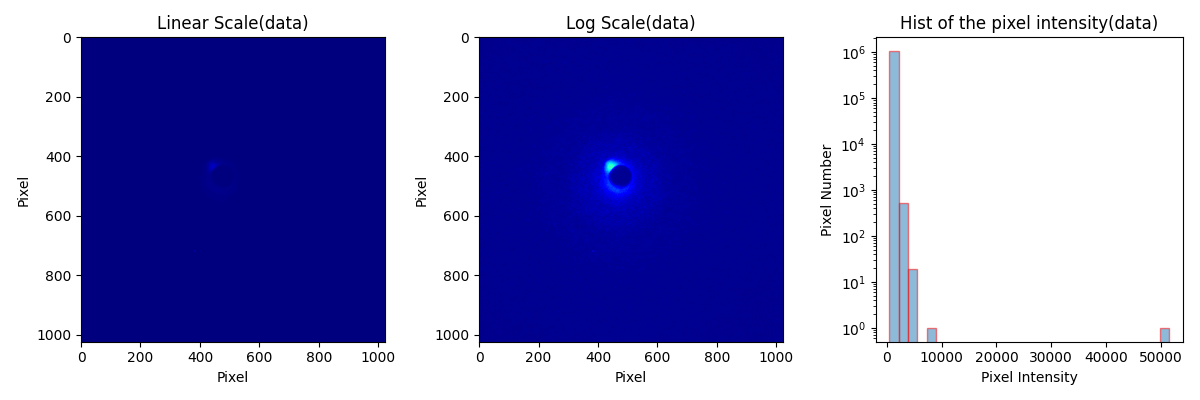

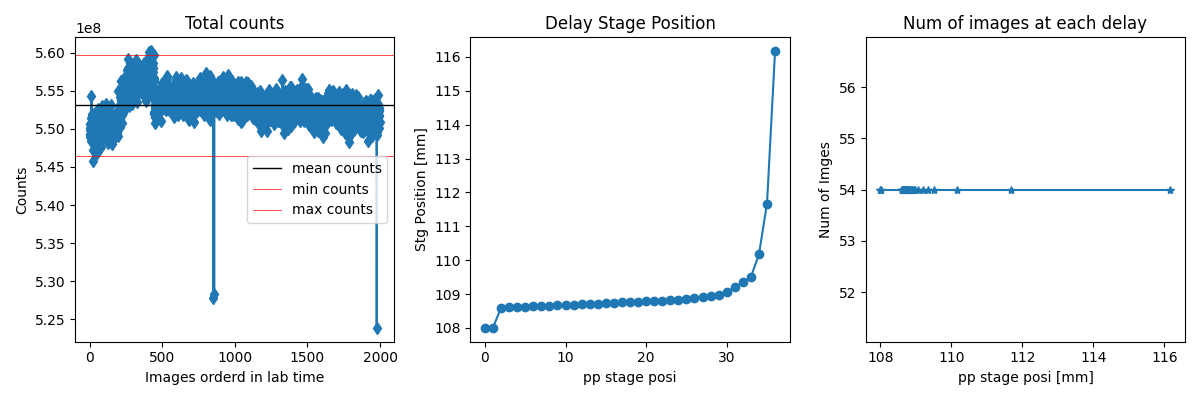

In [5]:
print('Loading diffraction signal');
data_array, stage_positions, file_numbers, counts = gued.get_image_details(files[:], sort=True, filter_data=False, plot=True)

center_ave = np.mean(counts)        # Mean values of Total Counts of all images
center_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


## Preprocess Data

6  number of files removed from  1998  initial files


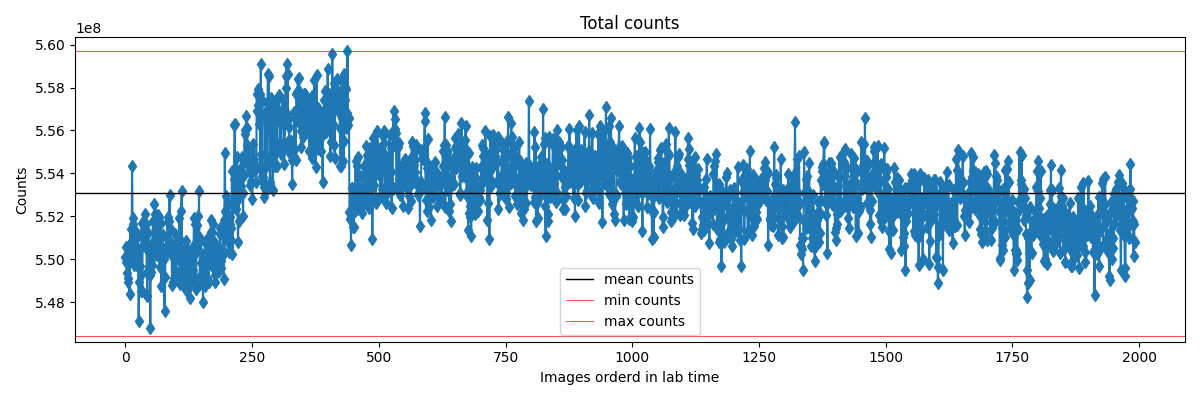

In [6]:
data_array, stage_positions, file_numbers, counts = gued.remove_counts(data_array, stage_positions, file_numbers, counts, plot=True)

## Averaging Based on Image Number

To reduce amount of data being processed and increase the reliability of center finding, create groups of different image sizes to average together. Recommended group size is 1% to 2.5% of data (i.e., if I have 2000 images I would pick a group size between 20-50 images per group)

In [7]:
group = False

if group == True:
    #Group images and average based on lab time
    grp_sz = 20
    groups = np.arange(0, len(file_numbers)+1, grp_sz)
    data_groups = []
    for i in range(len(groups)-1):
        ave_data = np.mean(data_array[groups[i]:groups[i+1]], axis=0)
        print("Averaging group: ", groups[i], "-", groups[i+1])
        data_groups.append(ave_data)
        
    data_groups = np.array(data_groups)
    print(data_groups.shape)
    data_array = data_groups
else:
    #select range of images
    data_array = data_array[250:500]


print(data_array.shape)

(250, 1024, 1024)


## Subtract Background

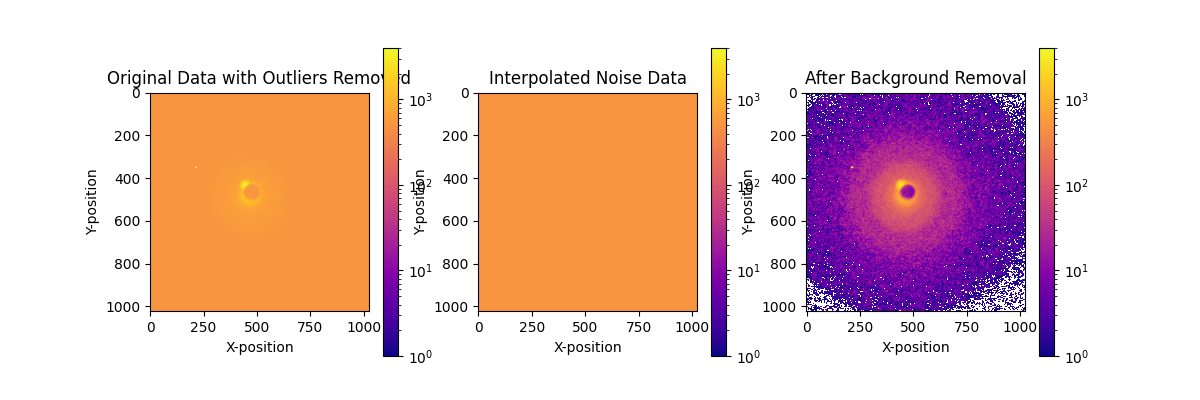

In [8]:
data_array = gued.remove_background_pool(data_array, remove_noise=True, plot=True)

## Remove Hot Pixels

Removing hot pixels from all data


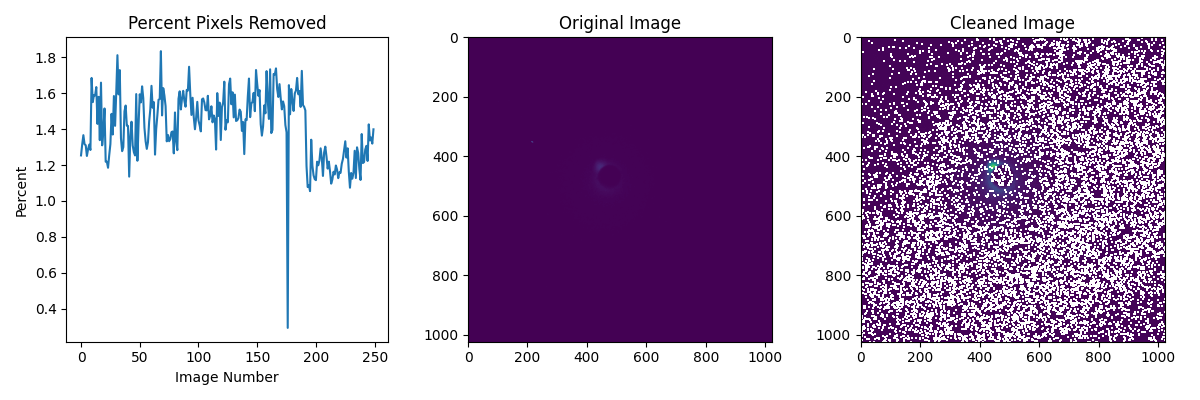

In [9]:
data_array = gued.remove_xrays_pool(data_array, plot=True)

## Mask Beam Block and Artifacts


Intensity value: 7.39
Intensity value: 9.49
Intensity value: 12.18
Intensity value: 15.64
Intensity value: 20.09
Intensity value: 25.79
Intensity value: 33.12
Intensity value: 42.52
Intensity value: 54.60
Intensity value: 70.11
Intensity value: 90.02
Intensity value: 115.58
Intensity value: 148.41
Intensity value: 190.57
Intensity value: 244.69
Intensity value: 314.19
Intensity value: 403.43
Intensity value: 518.01
Intensity value: 665.14
Intensity value: 854.06
Intensity value: 1096.63


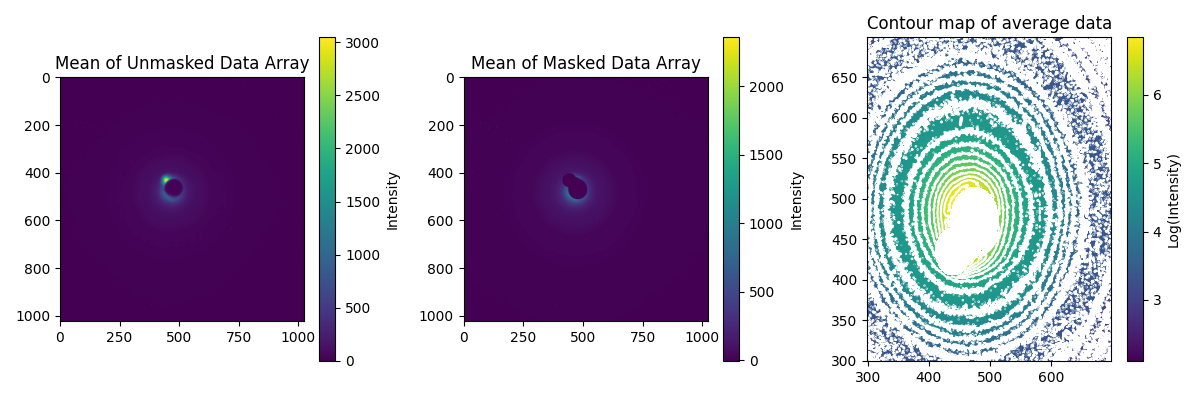

In [10]:
# Apply Mask
data_array = gued.apply_mask(data_array, fill_value= 0.0, plot=True, print_vals=True)

## Find Centers

First, adjust global variables using the `Set_up_Globals.ipynb` notebook to get centers accurately. Should not see center jumps more than one or two pixels. If this is happening you probably need to adjust global values

In [11]:
help(gued.find_center_pool)

Help on function find_center_pool in module gued:

find_center_pool(data_array, plot=True, print_stats=True)
    Finds center of each image in the data array using concurrent.futures.ThreadPoolExecutor to quickly process
    many data files.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        array of image like data with shape Nx1024x1024
    
    OPTIONAL ARGUMENTS:
    
    plot (boolean): 
        Default is set to True. When true, plots an image of the values for center_x and center_y with respect to pixel number
    print_stats (boolean): 
        Default is set to True. Prints the average value for center_x and center_y and prints the percent failure rate.
    
    GLOBAL VARIABLES:
    
    CENTER_GUESS (tuple): 
        initial guess for center position
    RADIUS_GUESS (int): 
        initial guess for the radius
    DISK_RADIUS (int): 
        value for disk radius used in mapping
    
    RETURNS:
    
    center_x (array):
        One-dimensional array of x values 

In [12]:
# First, check the threshold value being calculated by the code, a good value is usually close to 100
from skimage.filters import threshold_otsu
for data in data_array:
    print(threshold_otsu(data))

13.937213621907723
6497.505679198683
123.77402827553558
17592.005343741333
14745.579949242856
124.48912532895577
120.14280350074776
119.14203862702307
5453.718889222544
136.00368198423206
18503.853794737646
132.03731955499774
9755.988069792009
3139.2981176146204
7573.96688127567
57.89816634437359
119.76578614536795
22699.311277382265
3906.818142457122
119.9329728122848
130.2027343313755
115.56155963911976
111.70829334860224
10271.288676334203
119.36077677717846
109.02600587327413
131.7955734707024
104.04463527602317
131.276920048107
119.46780589889566
135.61024132480168
9310.520762887048
129.1042676688126
106.84319119099038
73.48041880292774
88.74525659100394
11924.982690500972
134.94746892184133
120.97951232030607
126.18371102881748
125.79760326869265
115.22118053344936
74.08221416319668
125.30803406925642
3180.9381138642207
120.22022268969202
117.64336655256346
32.69141943476812
85.01382545528371
125.89222118306814
68.9391804578759
18680.809124670464
133.01249469021803
13851.09159159

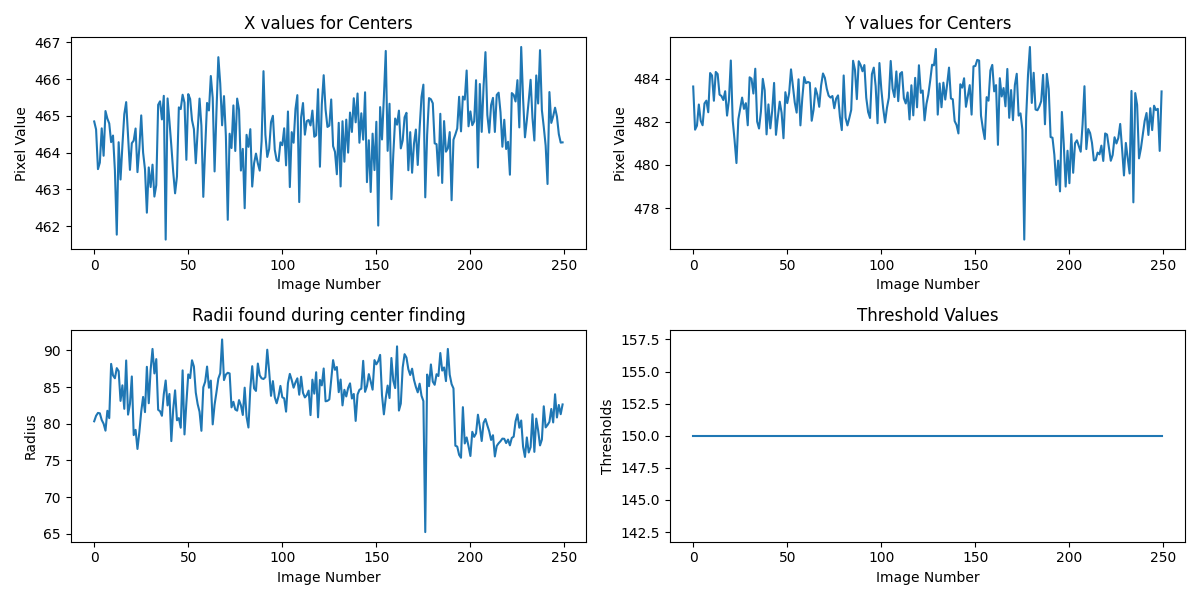

Averaged ctr is (np.float64(464.56485326412667), np.float64(482.63534644318963))
Percentage of images where the center finding failed (i.e., found the guess value): 0.0


In [13]:
center_x, center_y = gued.find_center_pool(data_array, plot=True)
centers = list(zip(center_x, center_y))

## Process All Data Next

Next, you can process all your data using the `process_all.py` python program with the correct globals to process all of your raw data and store it in an .h5 file for future use in the `PDF_Generation.ipynb` notebook